In [32]:


import xarray as xr
import pooch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


# save data to temporary location
flname = pooch.retrieve("http://berkeleyearth.lbl.gov/auto/Global/Gridded/Land_and_Ocean_LatLong1.nc", None)# read data into memory
ds = xr.open_dataset(flname)

In [50]:
ds.time

<xarray.DataArray 'time' (time: 2064)>
array(['1850-01-15T00:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-15T00:00:00.000000000', ..., '2021-10-15T00:00:00.000000000',
       '2021-11-15T00:00:00.000000000', '2021-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-15 1850-02-15 ... 2021-12-15

In [41]:
dates = pd.date_range(start=f'1850-01T00:00:00.000000000', 
                      end=f'2021-12T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
ds['time'] = dates

In [42]:
def area_grid(lat, lon):
    """
    Calculate the area of each grid cell
    Area is in square meters
    
    Input
    -----------
    lat: vector of latitude in degrees
    lon: vector of longitude in degrees
    
    Output
    -----------
    area: grid-cell area in square-meters with dimensions, [lat,lon]
    
    Notes
    -----------
    Based on the function in
    https://github.com/chadagreene/CDT/blob/master/cdt/cdtarea.m
    """
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)

    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))

    area = dy * dx

    xda = DataArray(
        area,
        dims=["latitude", "longitude"],
        coords={"latitude": lat, "longitude": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda

In [43]:
def earth_radius(lat):
    '''
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    
    Input
    ---------
    lat: vector or latitudes in degrees  
    
    Output
    ----------
    r: vector of radius in meters
    
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    '''
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r

In [44]:
grid_cell_area = area_grid(ds['latitude'].values, ds['longitude'].values)

In [45]:
standard_mean = ds['temperature'].mean(['latitude','longitude'])
standard_mean_smooth = standard_mean.rolling(time=12*5, center=True).mean().dropna("time")


In [46]:
total_area_of_earth = grid_cell_area.sum(['latitude','longitude'])
weighted_mean = ((ds['temperature'] * grid_cell_area) / total_area_of_earth).sum(['latitude','longitude'])


In [47]:
weighted_mean_smooth = weighted_mean.rolling(time=12*5, center=True).mean().dropna("time")



In [48]:
# area dataArray
da_area = area_grid(ds['latitude'], ds['longitude'])# total area
total_area = da_area.sum(['latitude','longitude'])# temperature weighted by grid-cell area
temp_weighted = (ds['temperature']*da_area) / total_area# area-weighted mean temperature
temp_weighted_mean = temp_weighted.sum(['latitude','longitude'])

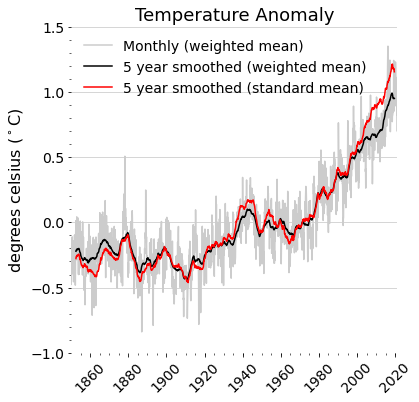

In [49]:
# --------------------------------------------
# setup the figure
# --------------------------------------------
fig = plt.figure(figsize=(6,6)) 
ax = fig.add_subplot(111)

# --------------------------------------------
# plot the data
# --------------------------------------------
#ax.plot(ds['time'], standard_mean, color=[1,0.8,0.8], label='Monthly (weighted mean)')
ax.plot(ds['time'], weighted_mean, color=[0.8,0.8,0.8], label='Monthly (weighted mean)')
ax.plot(weighted_mean_smooth['time'], weighted_mean_smooth, color='k', label='5 year smoothed (weighted mean)')
ax.plot(standard_mean_smooth['time'], standard_mean_smooth, color='r', label='5 year smoothed (standard mean)')

# --------------------------------------------
# plot legend
# --------------------------------------------
ax.legend(loc='upper left',frameon=False, fontsize=14)

# --------------------------------------------
# Range of axes
# --------------------------------------------
ax.set_ylim([-1, 1.5])
ax.set_xlim([np.datetime64('1850-01-15'), np.datetime64('2021-02-15')])

# --------------------------------------------
# Labels
# --------------------------------------------
ax.set_ylabel(f'degrees celsius ($^\circ$C)', fontsize=16)
ax.set_title(f'Temperature Anomaly', fontsize=18)

# --------------------------------------------
# Fontsize and rotation of axis labels
# --------------------------------------------
ax.tick_params(axis='x', rotation=45, labelsize=14)
ax.tick_params(axis='y', rotation=0, labelsize=14)

# --------------------------------------------
# Turn off the display of all ticks.
# --------------------------------------------
ax.tick_params(which='both',   # Options for both major and minor ticks
                top='off',     # turn off top ticks
                left='off',    # turn off left ticks
                right='off',   # turn off right ticks
                bottom='off',) # turn off bottom ticks


# --------------------------------------------
# Hide the right and top spines
# --------------------------------------------
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# --------------------------------------------
# major / minor tick spaces
# --------------------------------------------
ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(5)) 
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# --------------------------------------------
# Only show ticks on the left and bottom spines
# --------------------------------------------
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# --------------------------------------------
# Make axis square
# --------------------------------------------
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# --------------------------------------------
# Don't allow the axis to be on top of your data
# --------------------------------------------
ax.set_axisbelow(True)

# --------------------------------------------
# save figure
# --------------------------------------------
plt.savefig(f'./flux_time-series.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)